In [1]:
pip install seaborn matplotlib


Note: you may need to restart the kernel to use updated packages.


In [18]:
# pip install pydub
import numpy as np
import pandas as pd
import librosa
import scipy
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import os
import subprocess
import logging
from pathlib import Path
from pydub import AudioSegment
import tempfile

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

import joblib
from datetime import datetime

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.exceptions import UndefinedMetricWarning
import warnings

In [4]:
# pd.read_csv('audio_file/abc.csv')
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


# Set FFmpeg path
FFMPEG_PATH = r"C:/Users/saipprad/AppData/Local/miniconda3/Lib/site-packages/ffmpeg_ess/bin/ffmpeg.exe"  # Update this path to where you installed FFmpeg
FFPROBE_PATH = r"C:/Users/saipprad/AppData/Local/miniconda3/Lib/site-packages/ffmpeg_ess/bin/ffprobe.exe"  # Update this path to where you installed FFmpeg

AudioSegment.converter = FFMPEG_PATH
AudioSegment.ffmpeg = FFMPEG_PATH
AudioSegment.ffprobe = FFPROBE_PATH


In [19]:
class AudioClassifier:
    """Handles all aspects of audio classification"""
    
    def __init__(self, sample_rate=22050):
        # Standard audio sample rate (CD quality is 44100)
        self.sample_rate = sample_rate
        
        # Tools we need for processing
        self.scaler = StandardScaler()  # Makes features comparable
        self.label_encoder = LabelEncoder()  # Converts labels to numbers
        
        # Set up our classifier (Random Forest works well for audio)
        self.classifier = RandomForestClassifier(
            n_estimators=100,  # 100 trees is usually enough
            n_jobs=-1,        # Use all CPU cores
            random_state=42,  # For reproducibility
            class_weight='balanced'  # Handles uneven classes
        )
        
        # Make sure we have the tools we need
        self._check_ffmpeg()

    def _check_ffmpeg(self):
        """Make sure FFmpeg is installed and accessible"""
        if not os.path.exists(FFMPEG_PATH):
            print("\nError: FFmpeg not found!")
            print("Please follow these steps:")
            print("1. Download FFmpeg from: https://www.gyan.dev/ffmpeg/builds/")
            print("2. Extract it to C:\\ffmpeg")
            print("3. Update FFMPEG_PATH if you installed it somewhere else")
            raise Exception("FFmpeg not found")
        
        if not os.path.exists(FFPROBE_PATH):
            print("\nError: FFprobe not found!")
            raise Exception("FFprobe not found")
        
        print("✓ Found all required audio tools")

    def convert_to_wav(self, file_path):
        """Convert any audio file to WAV format for processing"""
        try:
            # Get absolute path and check if file exists
            file_path = Path(file_path).resolve()
            if not file_path.is_file():
                print(f"\nError: Can't find file: {file_path}")
                return None
            
            print(f"\nProcessing: {file_path.name}")
            print(f"File size: {file_path.stat().st_size / 1024:.1f} KB")
            
            # If it's already WAV, we're good
            if file_path.suffix.lower() == '.wav':
                return str(file_path)
            
            # Set up temporary folder for conversion
            temp_dir = Path(tempfile.gettempdir()) / "audio_conversion"
            temp_dir.mkdir(parents=True, exist_ok=True)
            temp_wav = temp_dir / f"{file_path.stem}_temp.wav"
            
            print(f"Converting to WAV format...")
            
            # Convert using FFmpeg
            command = [
                FFMPEG_PATH,
                '-i', str(file_path),
                '-acodec', 'pcm_s16le',
                '-ar', str(self.sample_rate),
                '-ac', '1',  # Convert to mono
                '-y',  # Overwrite if exists
                str(temp_wav)
            ]
            
            # Run FFmpeg silently
            process = subprocess.Popen(
                command,
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
                text=True
            )
            
            # Wait for conversion to finish
            _, stderr = process.communicate()
            
            if process.returncode == 0 and temp_wav.exists():
                print("✓ Conversion successful")
                return str(temp_wav)
            else:
                print(f"Error during conversion: {stderr}")
                return None
                
        except Exception as e:
            print(f"Error handling file: {str(e)}")
            return None

    def process_audio(self, file_path):
        """Load and process audio file"""
        try:
            # Convert to WAV first
            wav_path = self.convert_to_wav(file_path)
            if not wav_path:
                print(f"Couldn't process {file_path}")
                return None
            
            # Load the audio
            print("Loading audio file...")
            signal, _ = librosa.load(wav_path, sr=self.sample_rate, mono=True)
            
            # Handle very short audio
            if len(signal) < self.sample_rate:
                print("Audio too short, padding with silence...")
                signal = np.pad(signal, (0, self.sample_rate - len(signal)))
            
            # Standardize length (use first 5 seconds)
            if len(signal) > 5 * self.sample_rate:
                signal = signal[:5 * self.sample_rate]
            
            return signal
            
        except Exception as e:
            print(f"Error processing audio: {str(e)}")
            return None

    def extract_features(self, signal):
        """Get useful features from audio signal"""
        try:
            features = {}
            
            # Basic audio features
            print("Extracting audio features...")
            
            # Volume/energy features
            rms = librosa.feature.rms(y=signal)
            features.update({
                'rms_mean': float(np.mean(rms)),
                'rms_std': float(np.std(rms))
            })
            
            # Frequency features
            zcr = librosa.feature.zero_crossing_rate(signal)
            features.update({
                'zcr_mean': float(np.mean(zcr)),
                'zcr_std': float(np.std(zcr))
            })
            
            # Spectral features
            stft = librosa.stft(signal)
            magnitude = np.abs(stft)
            
            spectral_centroids = librosa.feature.spectral_centroid(S=magnitude)
            spectral_rolloff = librosa.feature.spectral_rolloff(S=magnitude)
            
            features.update({
                'spectral_centroid_mean': float(np.mean(spectral_centroids)),
                'spectral_centroid_std': float(np.std(spectral_centroids)),
                'spectral_rolloff_mean': float(np.mean(spectral_rolloff)),
                'spectral_rolloff_std': float(np.std(spectral_rolloff))
            })
            
            # Rhythm features
            tempo, _ = librosa.beat.beat_track(y=signal, sr=self.sample_rate)
            onset_env = librosa.onset.onset_strength(y=signal, sr=self.sample_rate)
            
            features.update({
                'tempo': float(tempo),
                'onset_strength_mean': float(np.mean(onset_env)),
                'onset_strength_std': float(np.std(onset_env))
            })
            
            # MFCC features (good for speech)
            mfccs = librosa.feature.mfcc(y=signal, sr=self.sample_rate, n_mfcc=13)
            for i in range(13):
                features.update({
                    f'mfcc{i+1}_mean': float(np.mean(mfccs[i])),
                    f'mfcc{i+1}_std': float(np.std(mfccs[i]))
                })
            
            return features
            
        except Exception as e:
            print(f"Error extracting features: {str(e)}")
            return None

    def train(self, audio_files, labels):
        """Train the classifier on audio files"""
        
        if not audio_files or not labels:
            print("No files or labels provided!")
            return None, None
        
        # Store processed data
        features_list = []
        valid_labels = []
        
        # Process each audio file
        print("\nProcessing audio files...")
        for file_path, label in zip(audio_files, labels):
            print(f"\nWorking on: {Path(file_path).name}")
            
            # Load and process audio
            signal = self.process_audio(file_path)
            if signal is None:
                print("Skipping this file due to processing error")
                continue
            
            # Get features
            features = self.extract_features(signal)
            if features is None:
                print("Skipping this file due to feature extraction error")
                continue
            
            features_list.append(features)
            valid_labels.append(label)
        
        if not features_list:
            print("No valid features extracted from any file!")
            return None, None
        
        # Prepare data for training
        X = pd.DataFrame(features_list)
        y = self.label_encoder.fit_transform(valid_labels)
        
        # Handle any missing values
        X = X.fillna(X.mean())
        
        # Show what we're working with
        print("\nDataset Summary:")
        for label, count in zip(self.label_encoder.classes_, np.bincount(y)):
            print(f"  {label}: {count} samples")
        
        # If we don't have enough data for splitting
        if len(X) < 2 or len(np.unique(y)) < 2:
            print("\nNot enough data for train-test split, using all data...")
            X_scaled = self.scaler.fit_transform(X)
            self.classifier.fit(X_scaled, y)
            return X_scaled, y
        
        # Split and train
        try:
            # Split data, keeping class proportions
            X_train, X_test, y_train, y_test = train_test_split(
                X, y,
                test_size=0.2,
                random_state=42,
                stratify=y
            )
            
            # Scale features
            X_train_scaled = self.scaler.fit_transform(X_train)
            X_test_scaled = self.scaler.transform(X_test)
            
            print("\nTraining model...")
            self.classifier.fit(X_train_scaled, y_train)
            
            # Check how we did
            self.evaluate(X_test_scaled, y_test)
            
            return X_test_scaled, y_test
            
        except Exception as e:
            print(f"\nError during training: {str(e)}")
            print("Falling back to using all data...")
            
            X_scaled = self.scaler.fit_transform(X)
            self.classifier.fit(X_scaled, y)
            
            return X_scaled, y

    def evaluate(self, X_test, y_test):
        """Check how well our model performs"""
        
        if len(X_test) < 2:
            print("Not enough test samples!")
            return
        
        # Make predictions
        y_pred = self.classifier.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, support = precision_recall_fscore_support(
            y_test, y_pred, zero_division=0
        )
        
        # Get our class labels
        classes = self.label_encoder.classes_
        
        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Print results
        print("\n=== Model Performance ===")
        print(f"\nOverall Accuracy: {accuracy:.3f}")
        
        print("\nPer-Class Performance:")
        print("\nClass      Precision  Recall     F1-Score  Samples")
        print("-" * 50)
        
        for i, label in enumerate(classes):
            print(f"{label:<10} {precision[i]:9.3f} {recall[i]:9.3f} "
                  f"{f1[i]:9.3f} {support[i]:8d}")
        
        # Calculate averages
        macro_precision = np.mean(precision)
        macro_recall = np.mean(recall)
        macro_f1 = np.mean(f1)
        
        weighted_precision = np.average(precision, weights=support)
        weighted_recall = np.average(recall, weights=support)
        weighted_f1 = np.average(f1, weights=support)
        
        print("\nOverall Metrics:")
        print("-" * 50)
        print(f"Macro Avg:  {macro_precision:9.3f} {macro_recall:9.3f} "
              f"{macro_f1:9.3f} {sum(support):8d}")
        print(f"Weight Avg: {weighted_precision:9.3f} {weighted_recall:9.3f} "
              f"{weighted_f1:9.3f} {sum(support):8d}")
        
        # Show confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=classes,
                   yticklabels=classes)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        # Show feature importance
        self._plot_feature_importance()
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': support,
            'confusion_matrix': cm
        }

    def _plot_feature_importance(self):
        """Show which features matter most"""
        
        # Get feature names
        feature_names = [
            'rms_mean', 'rms_std', 
            'zcr_mean', 'zcr_std',
            'spectral_centroid_mean', 'spectral_centroid_std',
            'spectral_rolloff_mean', 'spectral_rolloff_std',
            'tempo', 'onset_strength_mean', 'onset_strength_std'
        ]
        # Add MFCC feature names
        feature_names.extend([f'mfcc{i+1}_mean' for i in range(13)])
        feature_names.extend([f'mfcc{i+1}_std' for i in range(13)])
        
        # Create importance DataFrame
        importance_df = pd.DataFrame({
            'feature': feature_names[:len(self.classifier.feature_importances_)],
            'importance': self.classifier.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("\n=== Most Important Features ===")
        print(importance_df.head(10))
        
        # Plot
        plt.figure(figsize=(12, 6))
        sns.barplot(x='importance', y='feature', 
                   data=importance_df.head(10))
        plt.title('Top 10 Most Important Features')
        plt.tight_layout()
        plt.show()

    def predict(self, audio_file):
        """Predict the class of a new audio file"""
        try:
            print(f"\nAnalyzing: {Path(audio_file).name}")
            
            # Process the audio
            signal = self.process_audio(audio_file)
            if signal is None:
                return None
            
            # Extract features
            features = self.extract_features(signal)
            if features is None:
                return None
            
            # Prepare for prediction
            X = pd.DataFrame([features])
            X = X.fillna(X.mean())
            X_scaled = self.scaler.transform(X)
            
            # Get probabilities for each class
            probas = self.classifier.predict_proba(X_scaled)
            
            # Print results
            print("\nPrediction Results:")
            for i, prob in enumerate(probas[0]):
                label = self.label_encoder.classes_[i]
                print(f"  {label}: {prob:.3f}")
            
            return probas
            
        except Exception as e:
            print(f"Error during prediction: {str(e)}")
            return None

    def save_model(self, folder_path=None):
        """
        Save the trained model and all necessary preprocessing components
        
        Args:
            folder_path: Where to save the model (default: creates a 'models' folder)
        
        Returns:
            str: Path to the saved model folder
        """
        try:
            # Check if model is trained
            if not hasattr(self.classifier, 'classes_'):
                print("Error: Model hasn't been trained yet!")
                return None

            # Create default path if none provided
            if folder_path is None:
                folder_path = Path('models')
            else:
                folder_path = Path(folder_path)
            
            # Create folder with timestamp
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            model_folder = folder_path / f"audio_model_{timestamp}"
            model_folder.mkdir(parents=True, exist_ok=True)
            
            print(f"\nSaving model to: {model_folder}")
            
            # Save each component
            components = {
                'classifier.joblib': self.classifier,
                'scaler.joblib': self.scaler,
                'label_encoder.joblib': self.label_encoder,
                'sample_rate.txt': self.sample_rate
            }
            
            for filename, component in components.items():
                file_path = model_folder / filename
                if filename.endswith('.txt'):
                    # Save sample rate as text
                    with open(file_path, 'w') as f:
                        f.write(str(component))
                else:
                    # Save other components using joblib
                    joblib.dump(component, file_path)
            
            # Save model info
            model_info = {
                'classes': list(self.label_encoder.classes_),
                'n_features': len(self.classifier.feature_importances_),
                'created_at': timestamp
            }
            
            info_path = model_folder / 'model_info.txt'
            with open(info_path, 'w') as f:
                for key, value in model_info.items():
                    f.write(f"{key}: {value}\n")
            
            print("✓ Model saved successfully!")
            print("\nModel Information:")
            print(f"  Classes: {model_info['classes']}")
            print(f"  Features: {model_info['n_features']}")
            print(f"  Created: {model_info['created_at']}")
            
            return str(model_folder)
            
        except Exception as e:
            print(f"Error saving model: {str(e)}")
            return None

    def load_model(self, model_folder):
        """
        Load a previously saved model and all its components
        
        Args:
            model_folder: Path to the folder containing the saved model
            
        Returns:
            bool: True if loaded successfully, False otherwise
        """
        try:
            model_path = Path(model_folder)
            if not model_path.exists():
                print(f"Error: Model folder not found: {model_folder}")
                return False
            
            print(f"\nLoading model from: {model_folder}")
            
            # Load components
            self.classifier = joblib.load(model_path / 'classifier.joblib')
            self.scaler = joblib.load(model_path / 'scaler.joblib')
            self.label_encoder = joblib.load(model_path / 'label_encoder.joblib')
            
            # Load sample rate
            with open(model_path / 'sample_rate.txt', 'r') as f:
                self.sample_rate = int(f.read().strip())
            
            # Load and display model info
            info_path = model_path / 'model_info.txt'
            if info_path.exists():
                print("\nModel Information:")
                with open(info_path, 'r') as f:
                    for line in f:
                        print(f"  {line.strip()}")
            
            print("\n✓ Model loaded successfully!")
            return True
            
        except Exception as e:
            print(f"Error loading model: {str(e)}")
            return False


In [21]:
def main():
    print("Start main")
    
    """
    Example of how to use the AudioClassifier
    """
    # Add at the beginning of main()

    # Get current directory
    audio_dir = Path(r"C:/Users/saipprad/Documents/Personal/audio_file")
    
    if not audio_dir.exists():
        logger.error(f"Directory not found: {audio_dir}")
        return
        
    # Collect audio files and labels
    audio_files = []
    labels = []

    
    labels_df = pd.read_csv('labels.csv')
    label_dict = dict(zip(labels_df['filename'], labels_df['label']))
    print(label_dict)
    
    # Then modify the file collection loop
    for audio_file in audio_dir.iterdir():
        if audio_file.suffix.lower() in ['.wav', '.mp3', '.m4a', '.ogg']:
            file_path = str(audio_file.resolve())
            audio_files.append(file_path)
            print(audio_file.name)
            labels.append(label_dict.get(audio_file.name, 'unknown'))

    
    # Supported audio formats
    audio_extensions = ['.wav', '.mp3', '.m4a', '.ogg']
    
    print("iagurhjrj")
    print(labels)
    if len(audio_files) == 0:
        logger.error("No audio files found")
        return
        
    logger.info(f"Found {len(audio_files)} audio files")
    logger.info("Label distribution:")
    for label in set(labels):
        count = labels.count(label)
        logger.info(f"  {label}: {count} files")

        
    # Initialize classifier
    classifier = AudioClassifier()

    # Print dataset summary
    print("\n=== Dataset Summary ===")
    print(f"Total audio files: {len(audio_files)}")
    print("\nLabel distribution:")
    for label in set(labels):
        count = labels.count(label)
        print(f"  {label}: {count} files")
            
    # Train the model
    X_test, y_test = classifier.train(audio_files, labels)
    
    if X_test is None or y_test is None:
        logger.error("Training failed")
        return
        
    # prediction
    if len(audio_files) > 0:
        probas = classifier.predict(audio_files[0])
        if probas is not None:
            print("\nPrediction probabilities for first file:")
            for i, prob in enumerate(probas[0]):
                print(f"Class {i}: {prob:.3f}")

    # Save the model
    print("\n=== Saving Model ===")
    model_dir = Path("saved_audio_model")
    saved_path = classifier.save_model(model_dir)

    if saved_path:
        print(f"\nModel saved successfully!")
        print(f"Model location: {saved_path}")
        
        # Save the path for later use
        with open("last_model_path.txt", "w") as f:
            f.write(saved_path)
    else:
        print("\nError: Failed to save model!")
    

INFO:__main__:Found 11 audio files
INFO:__main__:Label distribution:
INFO:__main__:  music: 3 files
INFO:__main__:  noise: 4 files
INFO:__main__:  speech: 4 files


Start main
{'speech1.m4a': 'speech', 'speech2.m4a': 'speech', 'speech3.m4a': 'speech', 'noise1.m4a': 'noise', 'noise2.m4a': 'noise', 'music1.m4a': 'music', 'music2.m4a': 'music', 'music3.m4a': 'music', 'speech4.m4a': 'speech', 'noise3.m4a': 'noise', 'noise4.m4a': 'noise'}
music1.m4a
music2.m4a
music3.m4a
noise1.m4a
noise2.m4a
noise3.m4a
noise4.m4a
speech1.m4a
speech2.m4a
speech3.m4a
speech4.m4a
iagurhjrj
['music', 'music', 'music', 'noise', 'noise', 'noise', 'noise', 'speech', 'speech', 'speech', 'speech']
✓ Found all required audio tools

=== Dataset Summary ===
Total audio files: 11

Label distribution:
  music: 3 files
  noise: 4 files
  speech: 4 files

Processing audio files...

Working on: music1.m4a

Processing: music1.m4a
File size: 102.1 KB
Converting to WAV format...
✓ Conversion successful
Loading audio file...
Extracting audio features...

Working on: music2.m4a

Processing: music2.m4a
File size: 102.1 KB
Converting to WAV format...


C:\Users\saipprad\AppData\Local\Temp\ipykernel_12788\117505892.py:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'tempo': float(tempo),


✓ Conversion successful
Loading audio file...
Extracting audio features...

Working on: music3.m4a

Processing: music3.m4a
File size: 84.4 KB
Converting to WAV format...
✓ Conversion successful
Loading audio file...
Extracting audio features...

Working on: noise1.m4a

Processing: noise1.m4a
File size: 114.1 KB
Converting to WAV format...
✓ Conversion successful
Loading audio file...
Extracting audio features...

Working on: noise2.m4a

Processing: noise2.m4a
File size: 52.0 KB
Converting to WAV format...
✓ Conversion successful
Loading audio file...
Extracting audio features...

Working on: noise3.m4a

Processing: noise3.m4a
File size: 69.2 KB
Converting to WAV format...
✓ Conversion successful
Loading audio file...
Extracting audio features...

Working on: noise4.m4a

Processing: noise4.m4a
File size: 66.4 KB
Converting to WAV format...
✓ Conversion successful
Loading audio file...
Extracting audio features...

Working on: speech1.m4a

Processing: speech1.m4a
File size: 84.3 KB
Conve

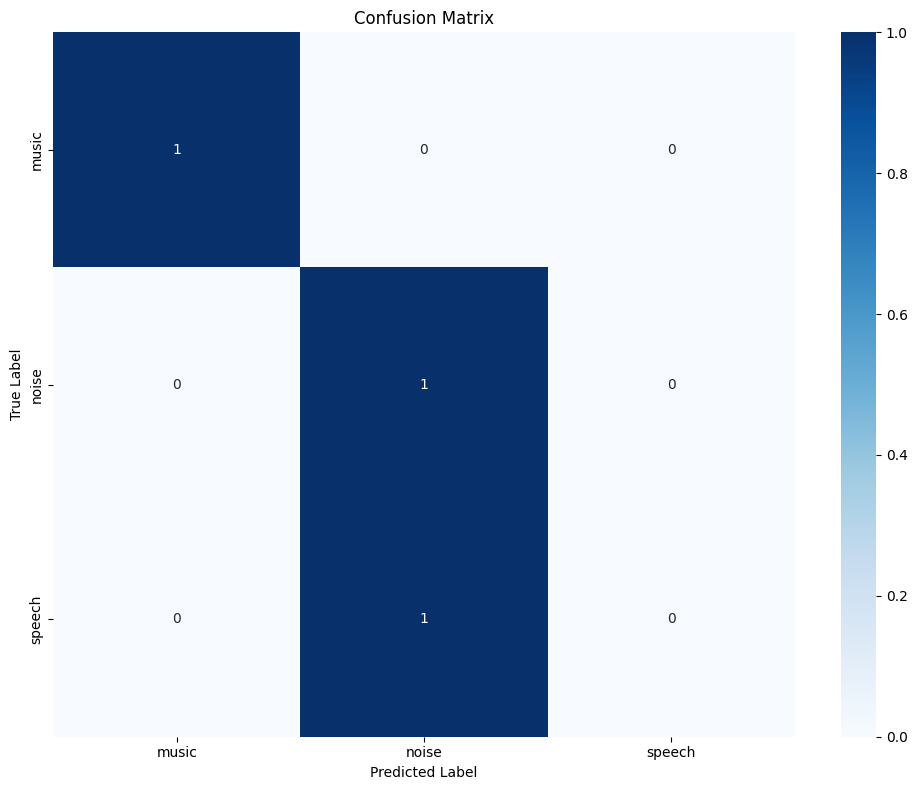


=== Most Important Features ===
                  feature  importance
33             mfcc10_std    0.113931
17             mfcc7_mean    0.075837
25              mfcc2_std    0.066240
5   spectral_centroid_std    0.065132
18             mfcc8_mean    0.049093
7    spectral_rolloff_std    0.047664
21            mfcc11_mean    0.046980
14             mfcc4_mean    0.046332
15             mfcc5_mean    0.044886
8                   tempo    0.040016


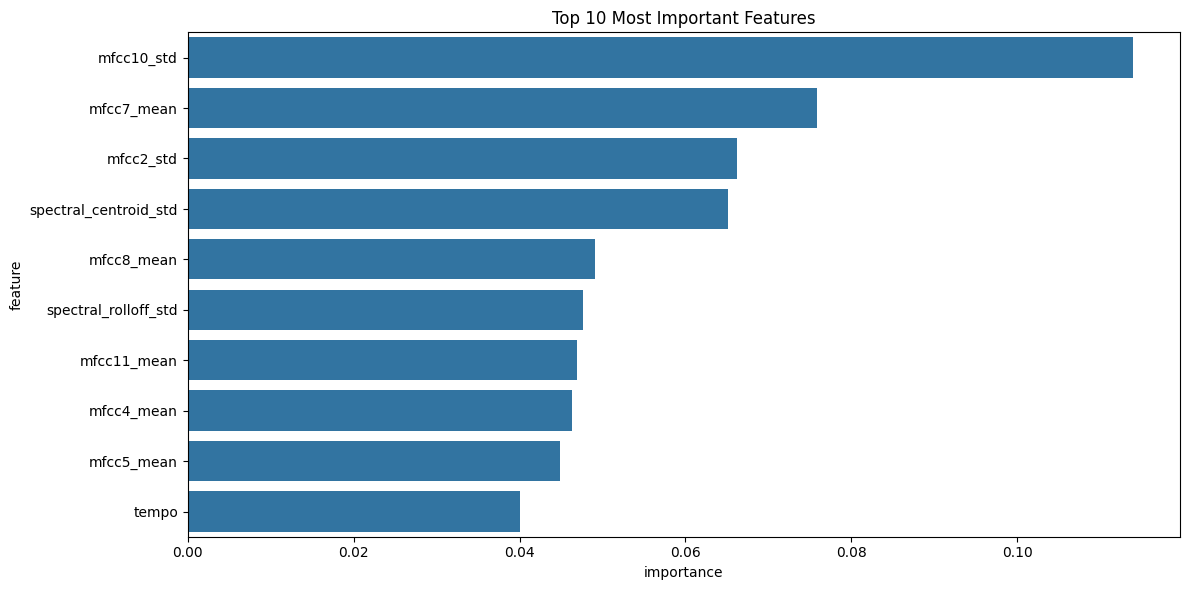


Analyzing: music1.m4a

Processing: music1.m4a
File size: 102.1 KB
Converting to WAV format...
✓ Conversion successful
Loading audio file...
Extracting audio features...

Prediction Results:
  music: 0.720
  noise: 0.250
  speech: 0.030

Prediction probabilities for first file:
Class 0: 0.720
Class 1: 0.250
Class 2: 0.030

=== Saving Model ===

Saving model to: saved_audio_model\audio_model_20250129_132106
✓ Model saved successfully!

Model Information:
  Classes: ['music', 'noise', 'speech']
  Features: 37
  Created: 20250129_132106

Model saved successfully!
Model location: saved_audio_model\audio_model_20250129_132106


C:\Users\saipprad\AppData\Local\Temp\ipykernel_12788\117505892.py:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'tempo': float(tempo),


In [22]:
if __name__ == "__main__":
    main()

In [23]:
def load_last_model():
    """Load the path of the last saved model"""
    try:
        with open("last_model_path.txt", "r") as f:
            return f.read().strip()
    except:
        return None


In [34]:
def predict_batch(classifier, audio_files):
    """Run predictions on multiple files"""
    results = {}
    
    for audio_file in audio_files:
        print(f"\nProcessing: {Path(audio_file).name}")
        
        # Make prediction
        result = classifier.predict(audio_file)
        
        if result is not None:
            results[str(audio_file)] = result
        else:
            print(f"Failed to process: {audio_file}")
    
    return results

def main():
    print("\n=== Audio Classifier Prediction ===")
    
    # Initialize the classifier
    classifier = AudioClassifier()

    # Get model path
    model_path = load_last_model()
    if not model_path:
        print("\nNo saved model path found!")
        model_path = input("Please enter the path to your model: ")
    
    # Load the model
    print(f"\nLoading model from: {model_path}")
    if not classifier.load_model(model_path):
        print("Failed to load model!")
        return

    audio_dir = Path(r"C:/Users/saipprad/Documents/Personal/audio_file/test")  # Add test directory
    audio_files = []
    
    # Supported audio formats
    audio_extensions = ['.wav', '.mp3', '.m4a', '.ogg']
    
    # Collect all audio files from the directory
    for ext in audio_extensions:
        audio_files.extend(list(audio_dir.glob(f"**/*{ext}")))
    
    if not audio_files:
        print("No audio files found!")
        return
    
    print(f"\nFound {len(audio_files)} audio files for prediction:")
    for file in audio_files:
        print(f"  - {file}")
    
    # Confirm
    print("\nReady to start predictions.")
    input("Press Enter to continue...")

    # predict
    print("\n=== Starting Predictions ===")
    results = predict_batch(classifier, audio_files)

    # show results
    print("\n=== Prediction Results ===")
    for file_path, probas in results.items():
        print(f"\nFile: {Path(file_path).name}")
        for i, prob in enumerate(probas[0]):
            label = classifier.label_encoder.classes_[i]
            print(f"  {label}: {prob:.3f}")

    # save results
    save_results = input("\nWould you like to save the results? (y/n): ")
    if save_results.lower() == 'y':
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        results_file = f"prediction_results_{timestamp}.txt"
        
        with open(results_file, 'w') as f:
            f.write("=== Prediction Results ===\n\n")
            for file_path, probas in results.items():
                f.write(f"\nFile: {Path(file_path).name}\n")
                for i, prob in enumerate(probas[0]):
                    label = classifier.label_encoder.classes_[i]
                    f.write(f"  {label}: {prob:.3f}\n")
        
        print(f"\nResults saved to: {results_file}")


In [35]:
if __name__ == "__main__":
    main()


=== Audio Classifier Prediction ===
✓ Found all required audio tools

Loading model from: saved_audio_model\audio_model_20250129_132335

Loading model from: saved_audio_model\audio_model_20250129_132335

Model Information:
  classes: ['music', 'noise', 'speech']
  n_features: 37
  created_at: 20250129_132335

✓ Model loaded successfully!

Found 1 audio files for prediction:
  - C:\Users\saipprad\Documents\Personal\audio_file\test\speech2.m4a

Ready to start predictions.


Press Enter to continue... 



=== Starting Predictions ===

Processing: speech2.m4a

Analyzing: speech2.m4a

Processing: speech2.m4a
File size: 41.1 KB
Converting to WAV format...
✓ Conversion successful
Loading audio file...
Extracting audio features...


C:\Users\saipprad\AppData\Local\Temp\ipykernel_12788\117505892.py:164: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'tempo': float(tempo),



Prediction Results:
  music: 0.060
  noise: 0.130
  speech: 0.810

=== Prediction Results ===

File: speech2.m4a
  music: 0.060
  noise: 0.130
  speech: 0.810



Would you like to save the results? (y/n):  n
